# Set up the working directory and enviroment

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Assign folders for storing input data, object, and output
1. 'data' folder: storing .mtx or h5 from 10xGenomic sequencing 
2. 'interim' folder: storing h5ad object after processing and its output files, e.g., top_markers.csv
3. 'figures' folder: automatically generated

In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/")

In [0]:
#! mkdir scanpy_out
results_file = 'scanpy_out/pool1_neuron_hNGN2.h5ad'

In [90]:
%ls intergrated_data/

concatenated_hNGN2.h5ad  integrate_hNGN2_28April2020.ipynb
concatenated_hNIL.h5ad   integrate_hNIL_28April2020.ipynb


In [94]:
%ls -lh ../scripts_lirong

total 31M
drwx------ 2 root root 4.0K Apr 27 20:28  backup_need_clean/
-rw------- 1 root root 1012 Apr 27 20:26  cellsnp_vireo_20April2020_corrected.sh
-rw------- 1 root root 5.0M Apr 28 18:55 'Copy of integrate datasets_26April2020.ipynb'
-rw------- 1 root root 2.1M Apr 27 20:27  demultiplexing_concise_template.ipynb
-rw------- 1 root root 4.3K Apr 27 20:27  demultiplexing_concise_template.py
-rw------- 1 root root 3.9K Apr 29 19:22  integrate_ipsc_28april2020.py
-rw------- 1 root root 8.9M Apr 29 20:17  integrate_iPSC_hNIL_29April2020.ipynb
-rw------- 1 root root 8.9M Apr 29 20:18  integrate_iPSC_hNIL_29April2020_long.ipynb
-rw------- 1 root root 4.9M Apr 29 20:18  scanpy_template.ipynb
-rw------- 1 root root 1.8K Apr 13 17:53  scanpy_visualize_marker_genes.ipynb
-rw------- 1 root root 760K Apr 20 18:53  trajectory_combined2_hNGN2_15April.ipynb


In [0]:
%%bash
cd ../scripts_lirong
cp integrate_iPSC_hNIL_29April2020.ipynb integrate_iPSC_hNIL_29April2020_long.ipynb

In [73]:
# 
%%bash
cd Florian_data/cortical_dopaminergic/
tar xf 'Copy of SLX-18809.HHY5CDRXX.s_1.lostreads.tar'

Process is interrupted.


In [70]:
!tar --help


Usage: tar [OPTION...] [FILE]...
GNU 'tar' saves many files together into a single tape or disk archive, and can
restore individual files from the archive.

Examples:
  tar -cf archive.tar foo bar  # Create archive.tar from files foo and bar.
  tar -tvf archive.tar         # List all files in archive.tar verbosely.
  tar -xf archive.tar          # Extract all files from archive.tar.

 Local file name selection:

      --add-file=FILE        add given FILE to the archive (useful if its name
                             starts with a dash)
  -C, --directory=DIR        change to directory DIR
      --exclude=PATTERN      exclude files, given as a PATTERN
      --exclude-backups      exclude backup and lock files
      --exclude-caches       exclude contents of directories containing
                             CACHEDIR.TAG, except for the tag file itself
      --exclude-caches-all   exclude directories containing CACHEDIR.TAG
      --exclude-caches-under exclude everything under director

## Installed the required packages

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

## Set up the displaying and print parameters

In [0]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


# Data preprocessing
1. Use gene symbols for the variable names (variables-axis index)
3. Write a cache file for faster subsequent reading
4. De-duplicates

## Read 10xGenomics sc-RNA sequencing data

In [0]:
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")                               

reading filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [0]:
adata.var_names_make_unique()

In [0]:
adata

AnnData object with n_obs × n_vars = 10797 × 33538 
    var: 'gene_ids', 'feature_types', 'genome'

## Basic filtering
1. cell based filtering: remove cells with less than 200 genes
2. gene based filtering: remove genes expressing in less than 3 cells

In [0]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6 cells that have less than 200 genes expressed
filtered out 12662 genes that are detected in less than 3 cells


## Calculate the percentage of mitochondrial genes

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## Check sequencing quality
1. choose the threthold of gene numbers to remove, e.g., n_genes = 7000
2. choose the threthold of mitochondial genes to remove, e.g., percent_mito = 0.25

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
... storing 'feature_types' as categorical
... storing 'genome' as categorical


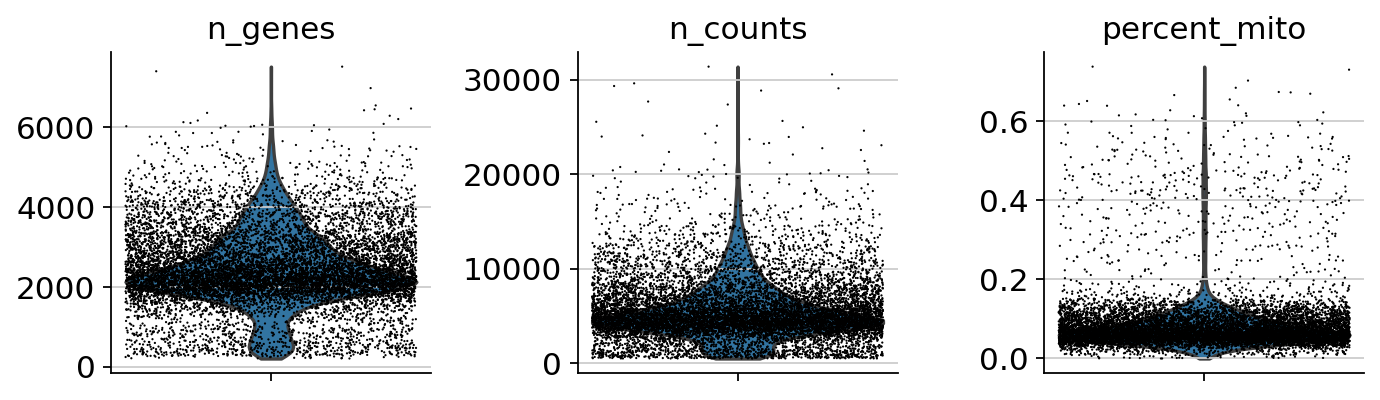

In [0]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

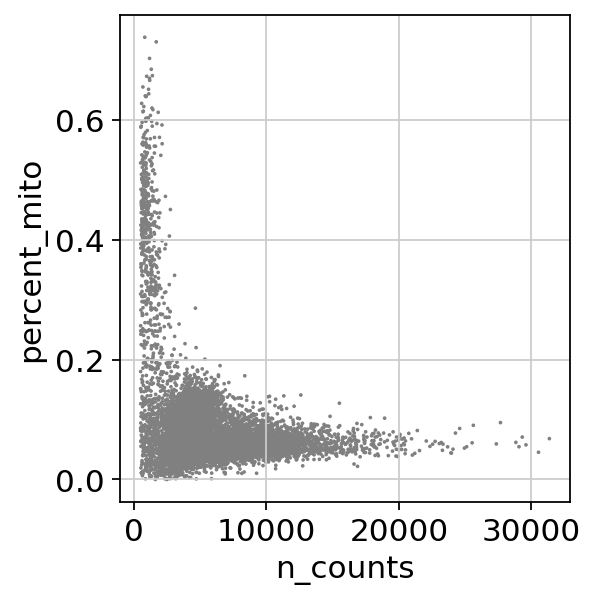

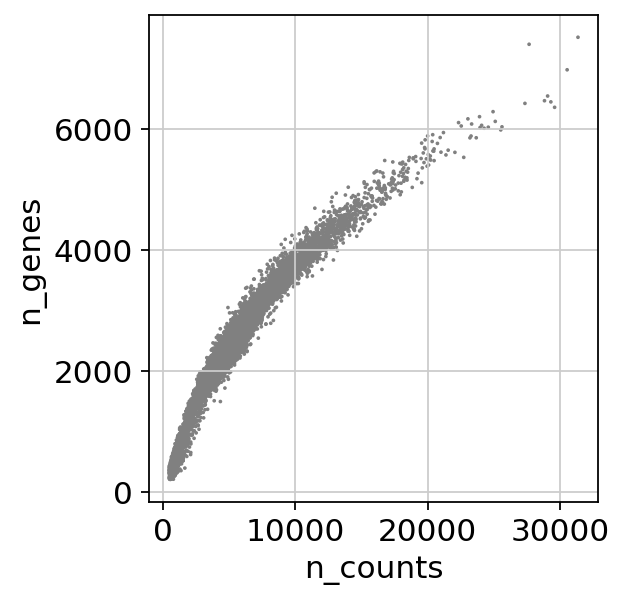

In [0]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [0]:
adata = adata[adata.obs.n_genes < 7500, :]
adata = adata[adata.obs.percent_mito < 0.25, :]
adata

View of AnnData object with n_obs × n_vars = 10342 × 20876 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Scale and logarithmize the data
option: store the unnormalized data in .raw

In [0]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata

normalizing counts per cell
    finished (0:00:21)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Choosing highly-variable genes for further analysis
Subset is optional. If subset using adata.var.highly_variable, the adata will only contain these genes.

This time, let's try do not subset

In [0]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


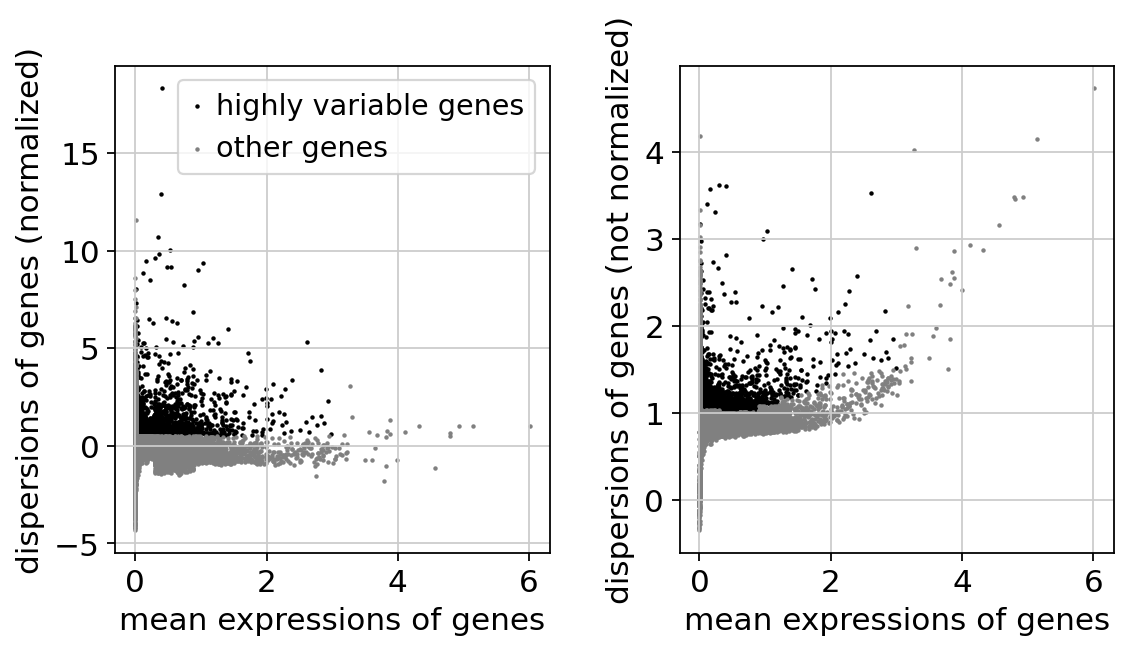

In [0]:
sc.pl.highly_variable_genes(adata)

In [0]:
# adata = adata[:, adata.var.highly_variable]

In [0]:
adata

AnnData object with n_obs × n_vars = 10342 × 20876 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Further scale on cofounder "n_counts" and "percent_mito"
1. Regression out n_counts and percent_mito effect and scale again on adata which only contains highly-variable genes now.
2. Clip values exceeding standard deviation 10 (max_value=10)

In [0]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:03:48)


# Principal component analysis

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:05)


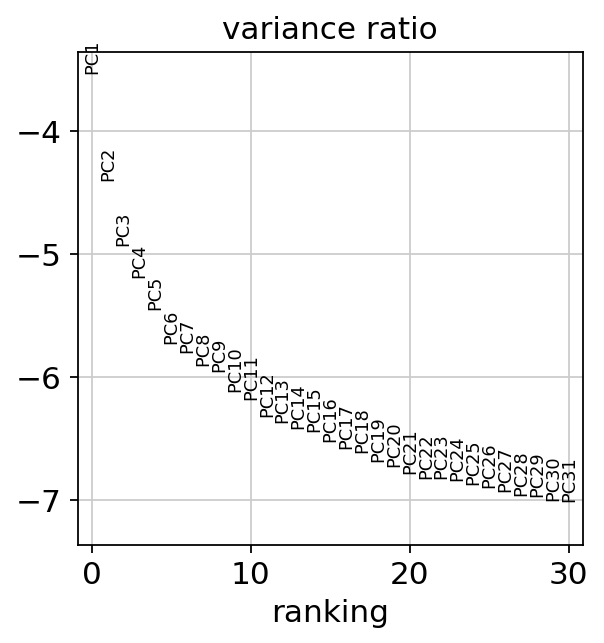

In [0]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


### Computing, embedding, and clustering the neighborhood graph

1. Computing the neighborhood graph of cells using the PCA representation of the data matrix.
2. Embedding the graph in 2 dimensions using UMAP.
3. Clustering the neighborhood graph using Leiden graph-clustering method 

In [0]:
 # defaults are: n_neighbors= 20, n_pcs=50, resolution=1.0
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [0]:
adata

AnnData object with n_obs × n_vars = 10342 × 20876 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [0]:
sc.tl.leiden(adata, resolution=0.4, key_added = "leiden_0.8")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:02)


## Visualize the clusters

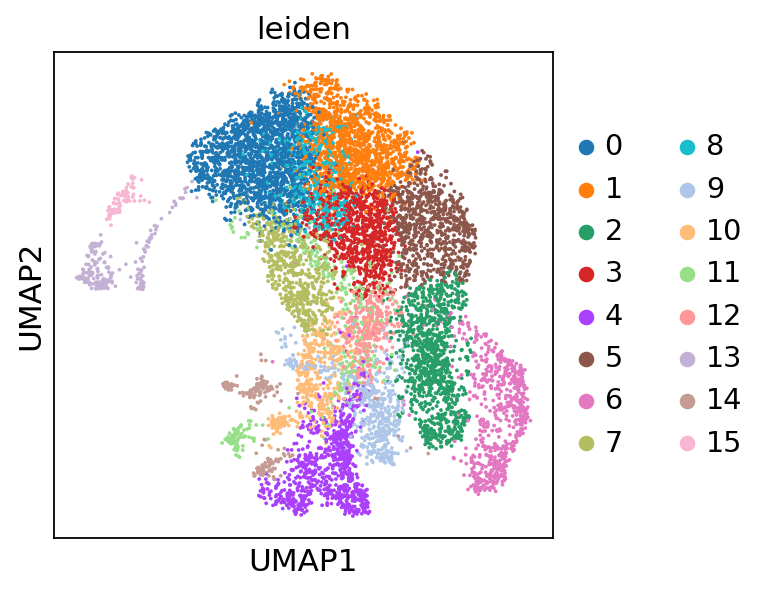

In [0]:
sc.pl.umap(adata, color=['leiden'])

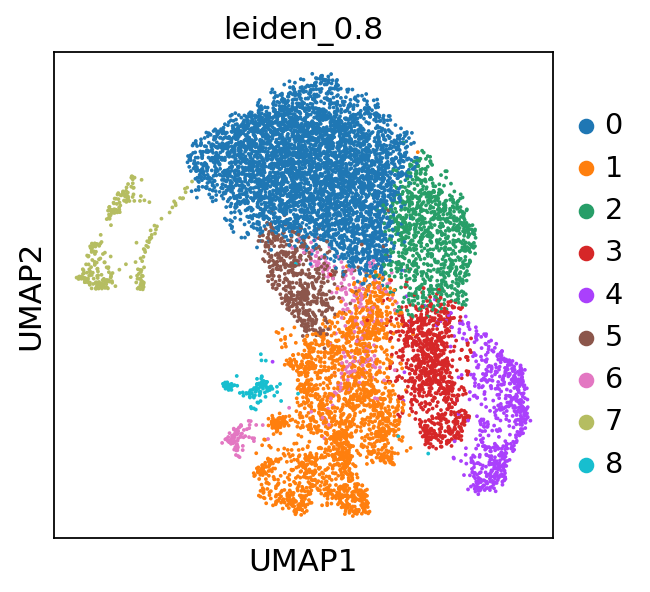

In [0]:
sc.pl.umap(adata, color=['leiden_0.8'])

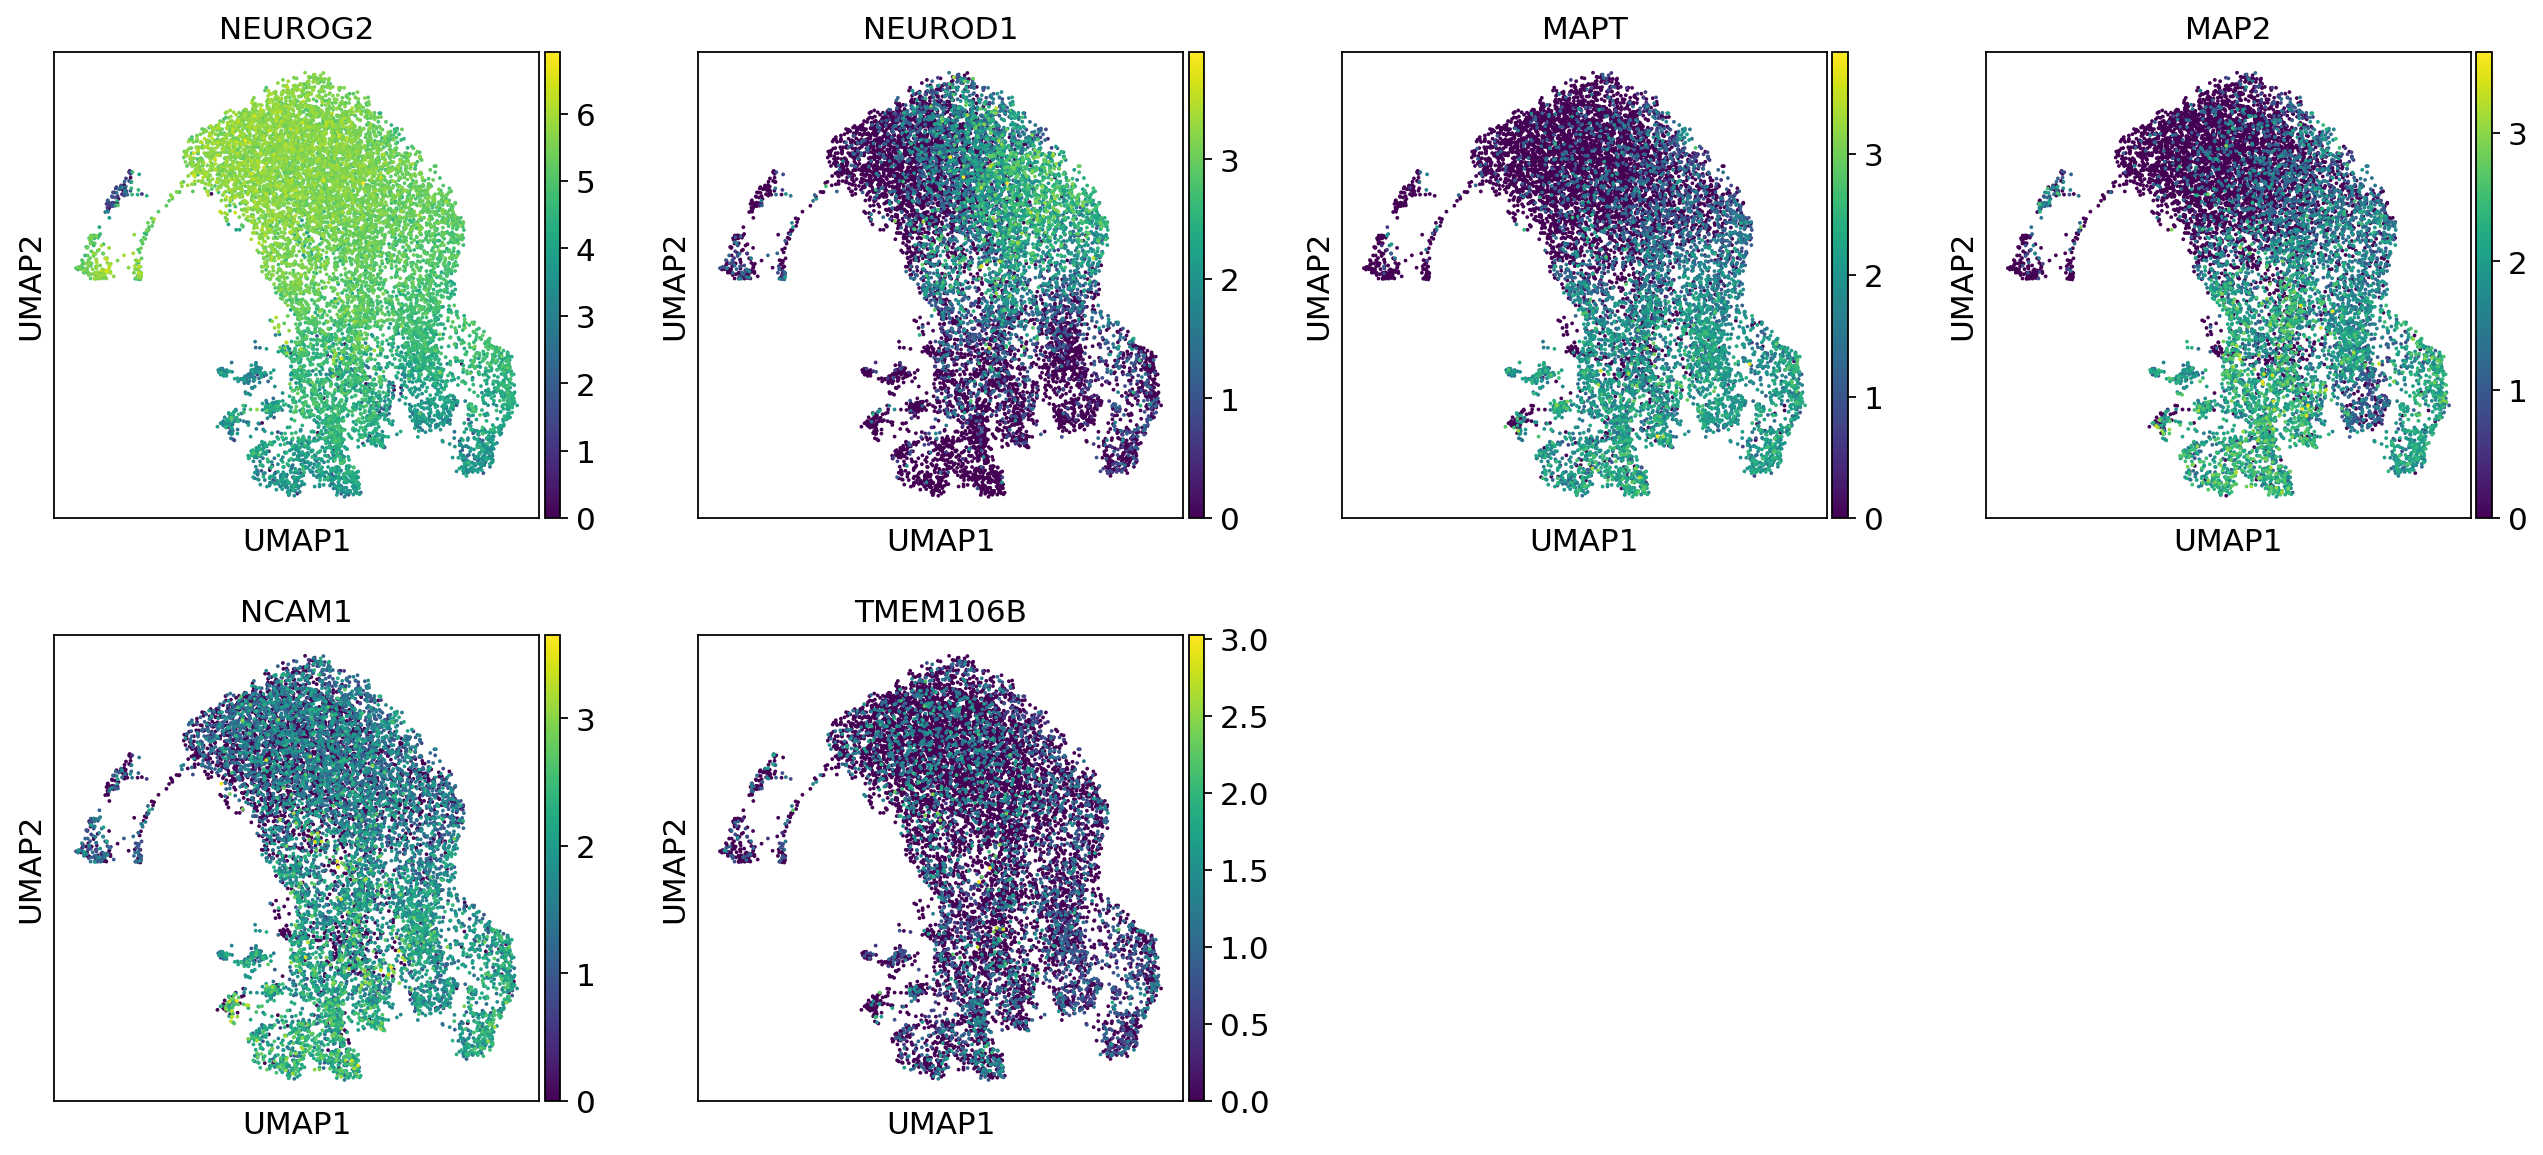

In [0]:
sc.pl.umap(adata, color=['NEUROG2', 'NEUROD1','MAPT','MAP2', 'NCAM1', 'TMEM106B'])

In [0]:
adata

AnnData object with n_obs × n_vars = 10342 × 2814 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'leiden_0.4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_0.4_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Save the processed adata object saved as .h5ad
The object can be load using adata = sc.read(results_file)

In [0]:
adata.write(results_file)

In [0]:
%ls

analysis_10xgenomics/        filtered_feature_bc_matrix.h5  scanpy_out/
barcodes.tsv.gz              possorted_genome_bam.bam       web_summary.html
filtered_feature_bc_matrix/  possorted_genome_bam.bam.bai


# Finding marker genes
one vs rest comparison using Mann-Whitney-U-test (recommend)

In [0]:
# reduce the verbosity from 3 to 2 in the setting of logging output
sc.settings.verbosity = 2 

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


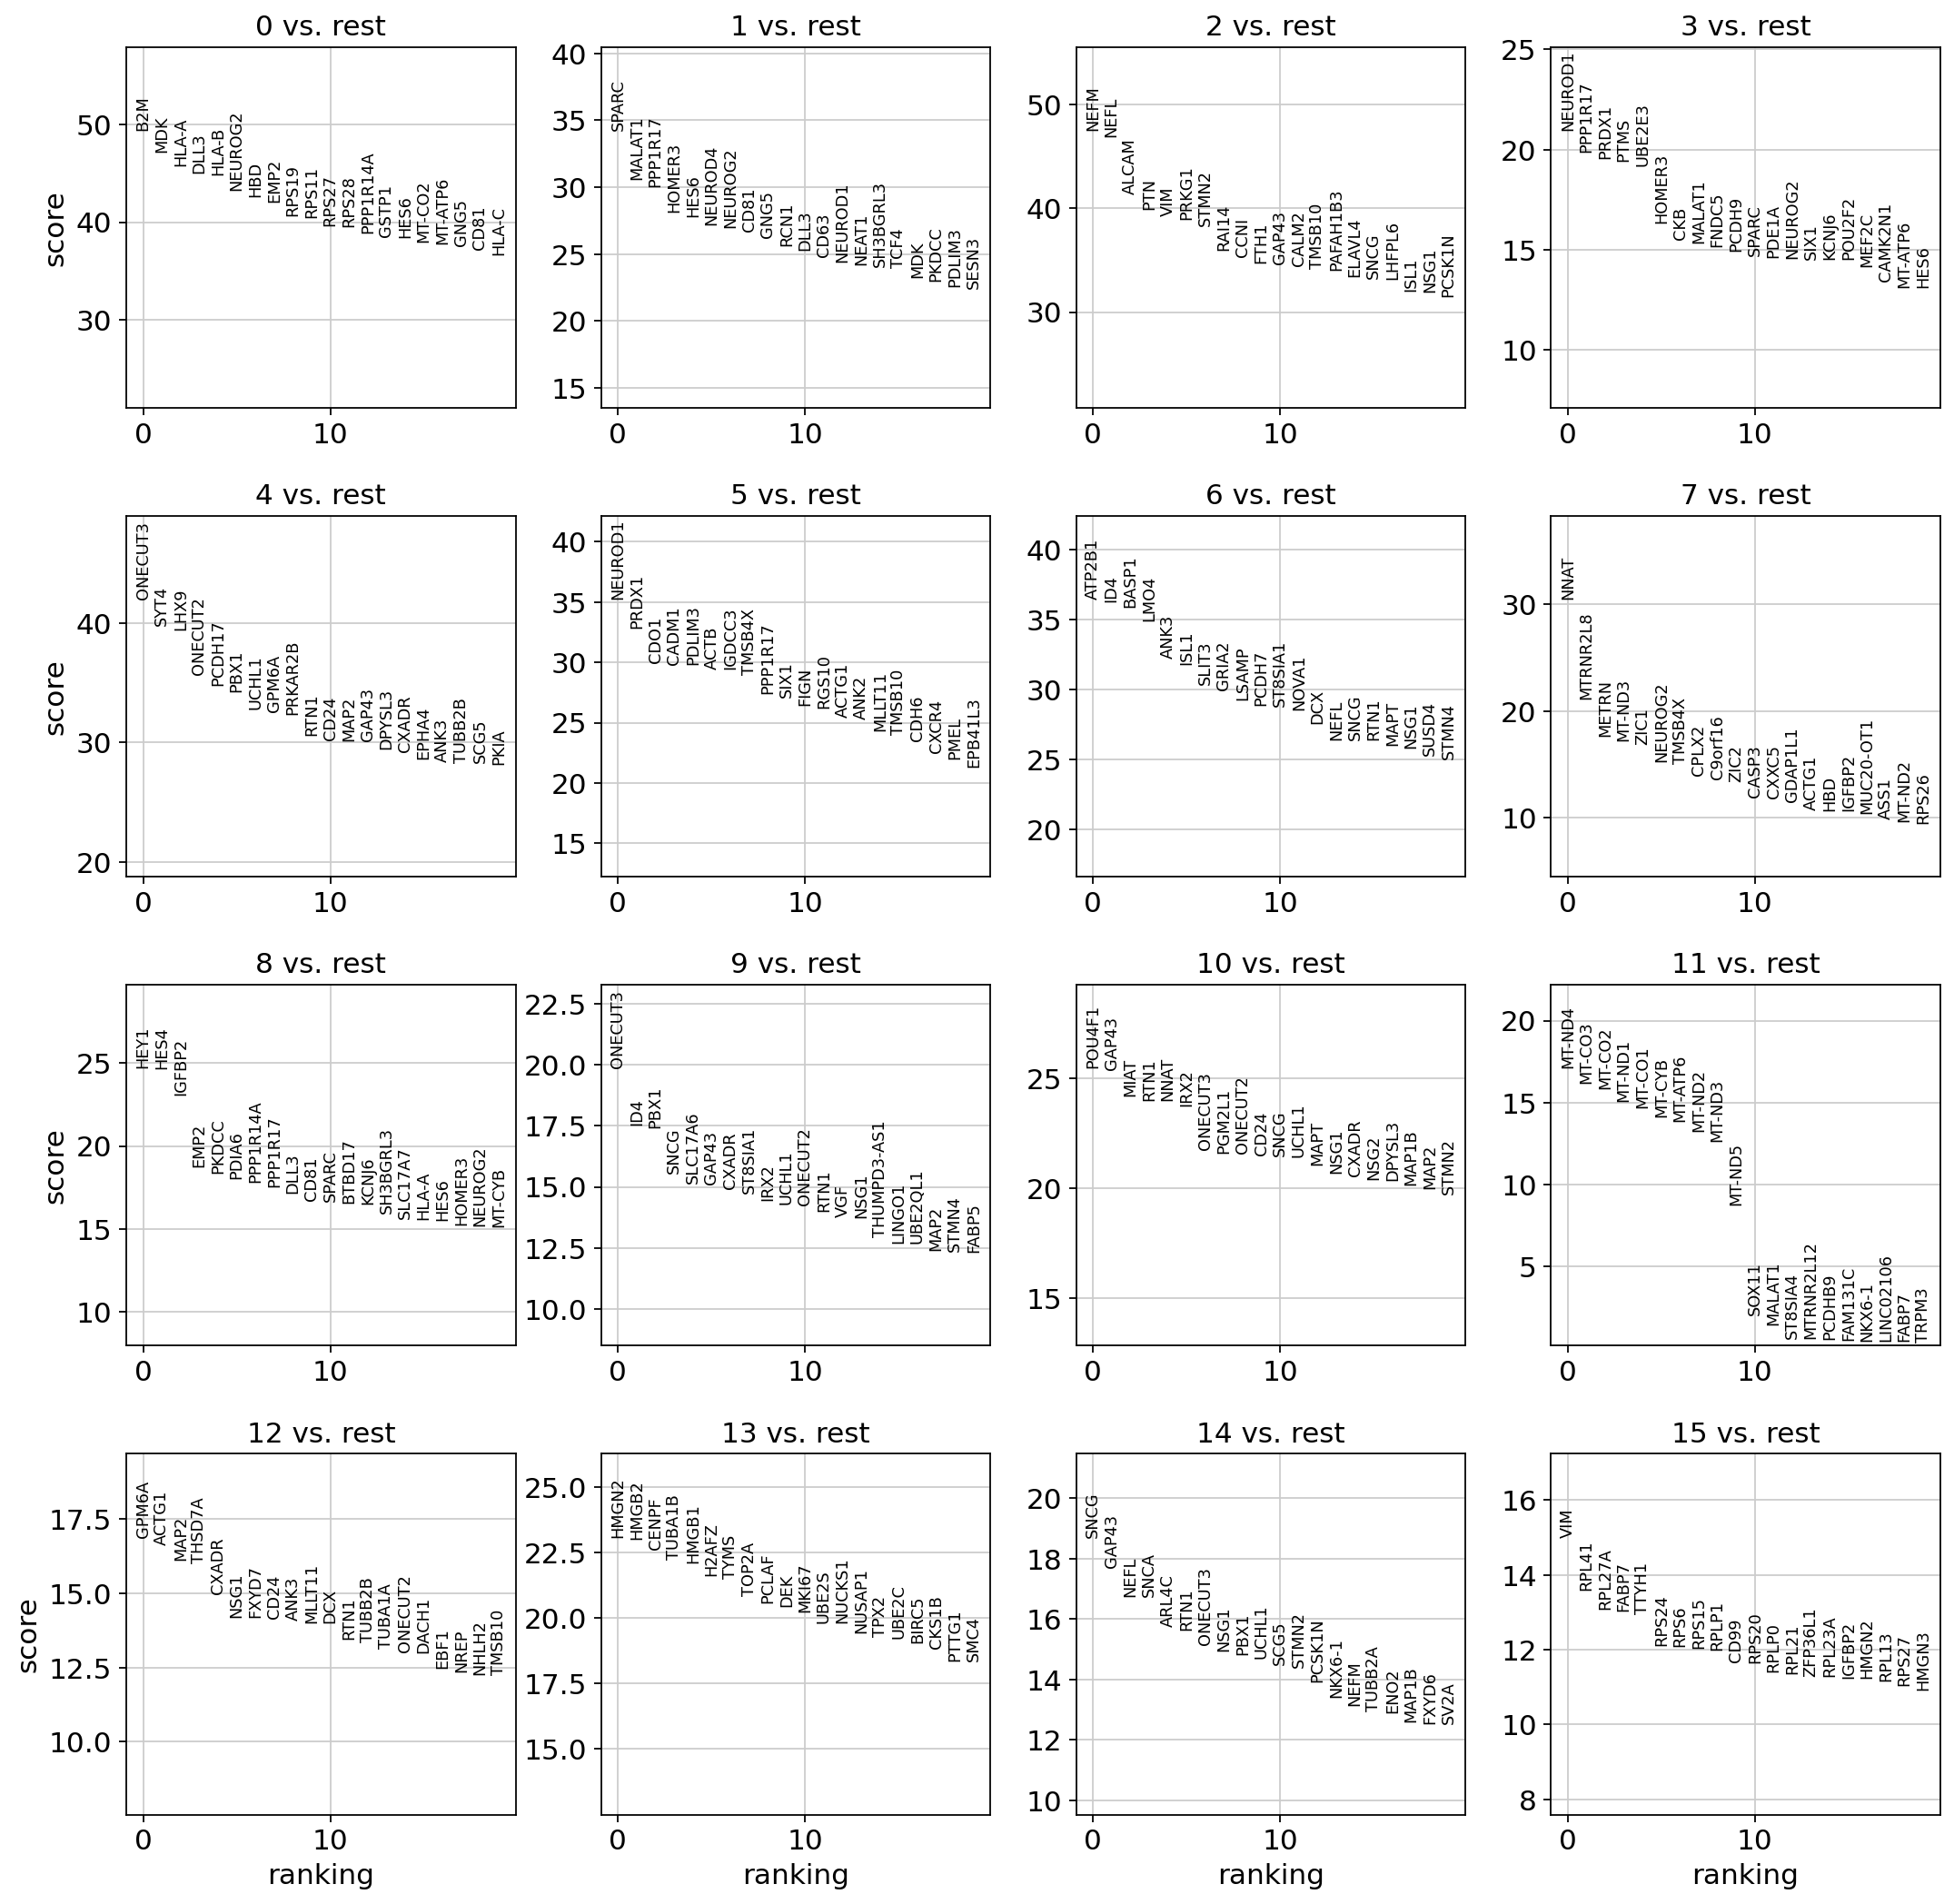

In [0]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Visualize the differential expression of marker genes across clusters
1. Differential expression a set of marker genes of a specific cluster vs the rest.
2. Differential expression of a single gene across all clusters

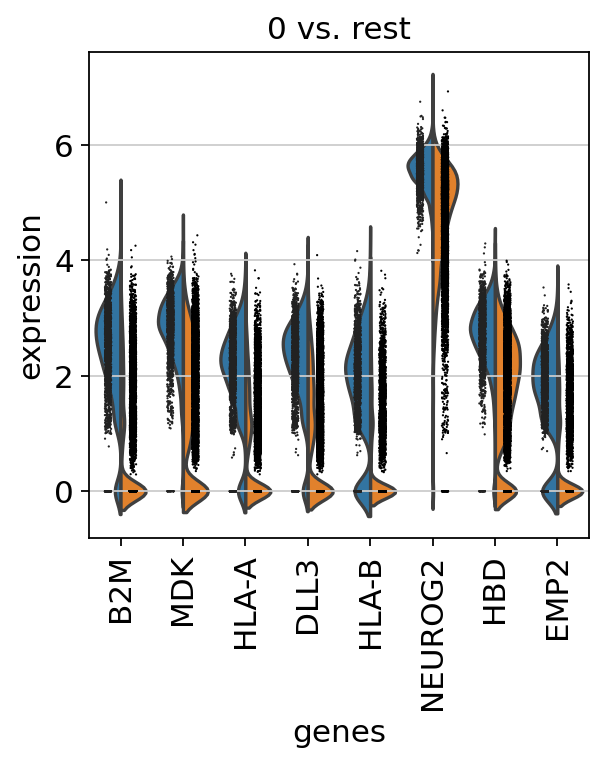

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

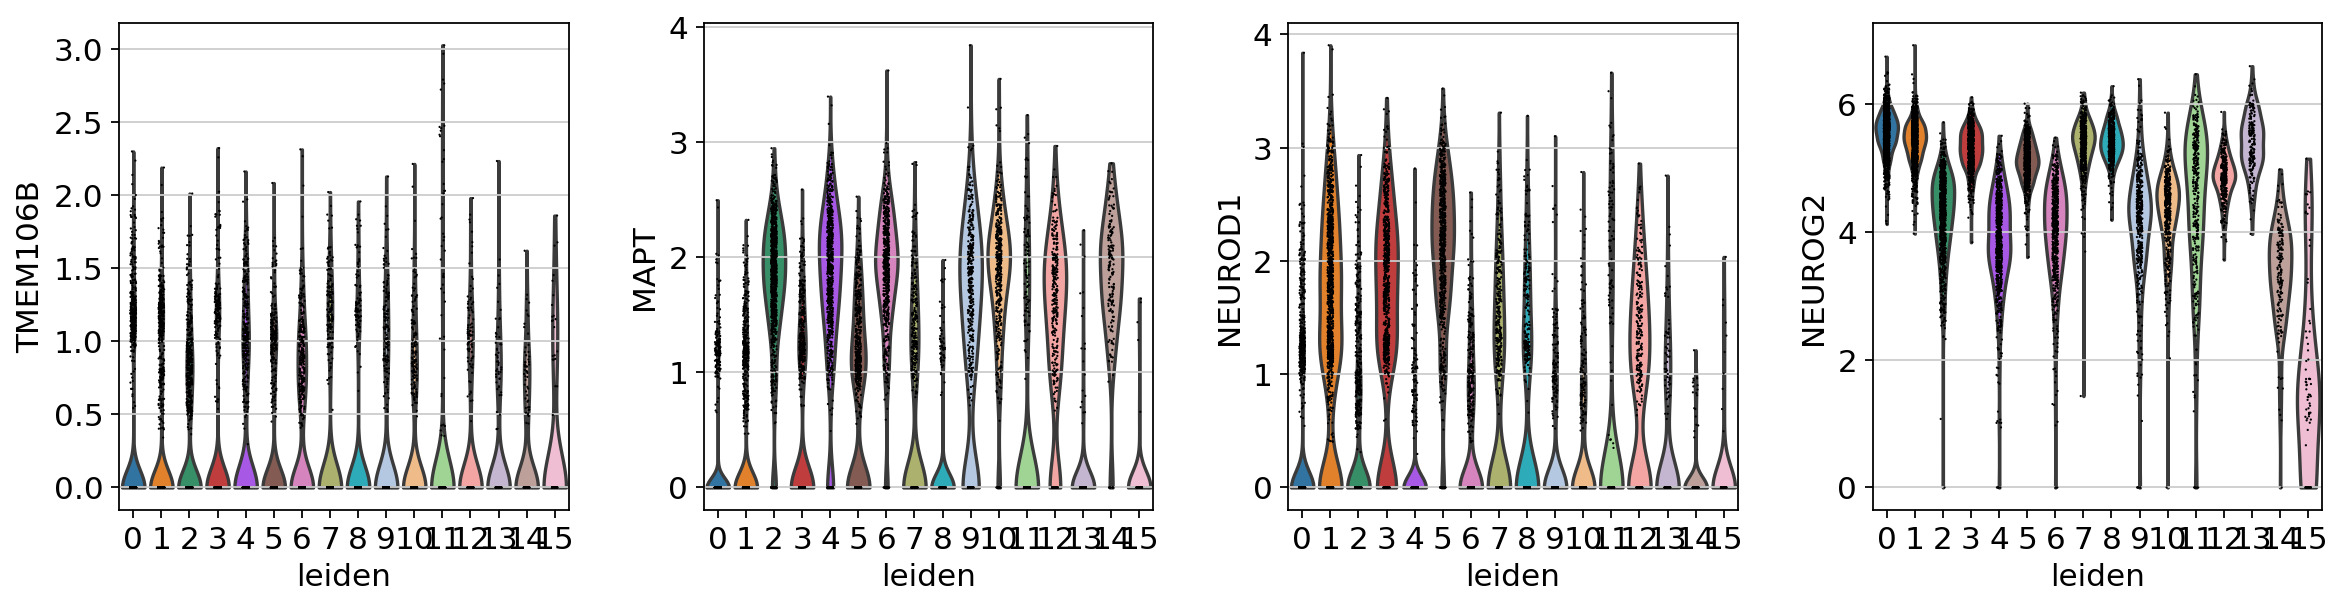

In [0]:
sc.pl.violin(adata, ['TMEM106B', 'MAPT', "NEUROD1", "NEUROG2"], groupby='leiden')

## Annotate cell types for all the clusters 
Based on domain knowledge and information of marker genes

Wait for disscussion for this case


In [0]:
# assign cell type names to the clusters
# new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']

# adata.rename_categories('leiden', new_cluster_names)

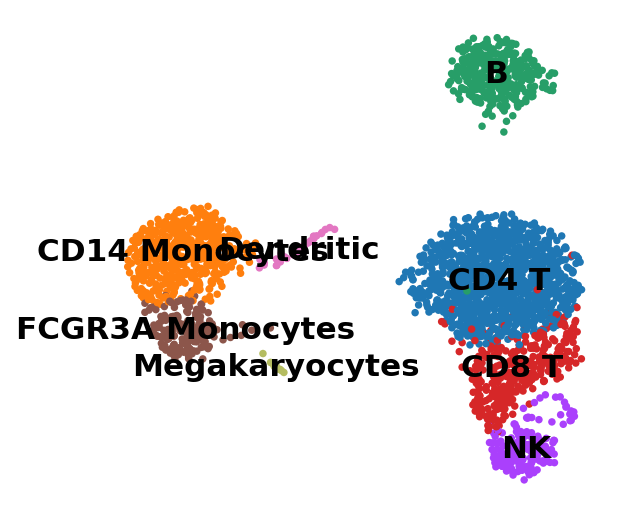

In [0]:
# it automatically generates a folder of 'figures' and save the figure inside 
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

# Export a list of marker genes

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

top_marker_genes.to_csv('scanpy_out/top_markers_pool1_neurons_hNGN2.csv')

In [0]:
top_marker_genes.head()

0_n  0_p      1_n  ...          14_p    15_n          15_p
0    B2M  0.0    SPARC  ...  4.411610e-78     VIM  6.550626e-51
1    MDK  0.0   MALAT1  ...  3.933927e-70   RPL41  5.018682e-42
2  HLA-A  0.0  PPP1R17  ...  5.926575e-63  RPL27A  5.171202e-39
3   DLL3  0.0   HOMER3  ...  6.461403e-63   FABP7  7.541312e-39
4  HLA-B  0.0     HES6  ...  6.110388e-56   TTYH1  2.062580e-38

[5 rows x 32 columns]

In [0]:
# get a list of top20 marker genes of cluster 1
marker_genes_cluster1 = top_marker_genes["1_n"][:20].values

# Visulize gene differential expression 
maker genes or other gene of interest


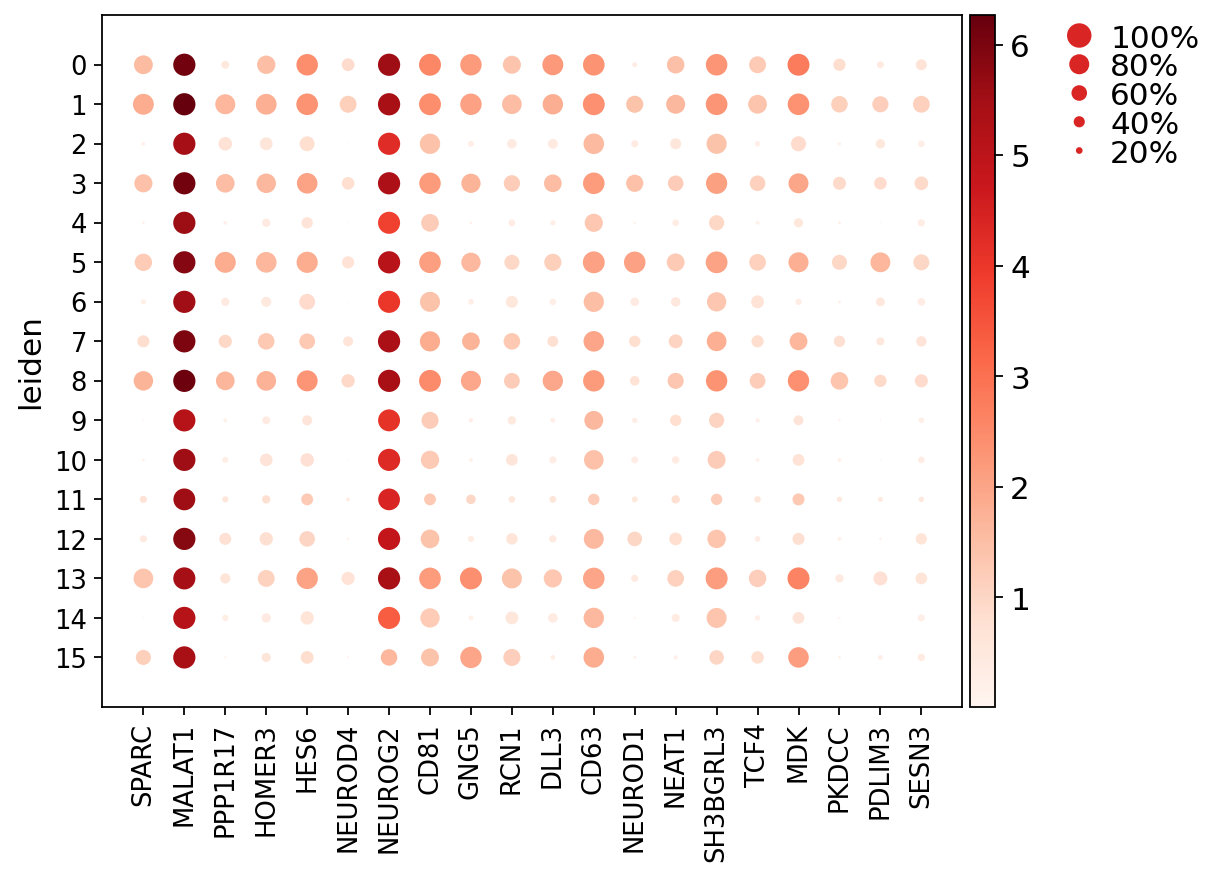

In [0]:
ax = sc.pl.dotplot(adata, marker_genes_cluster1, groupby='leiden')

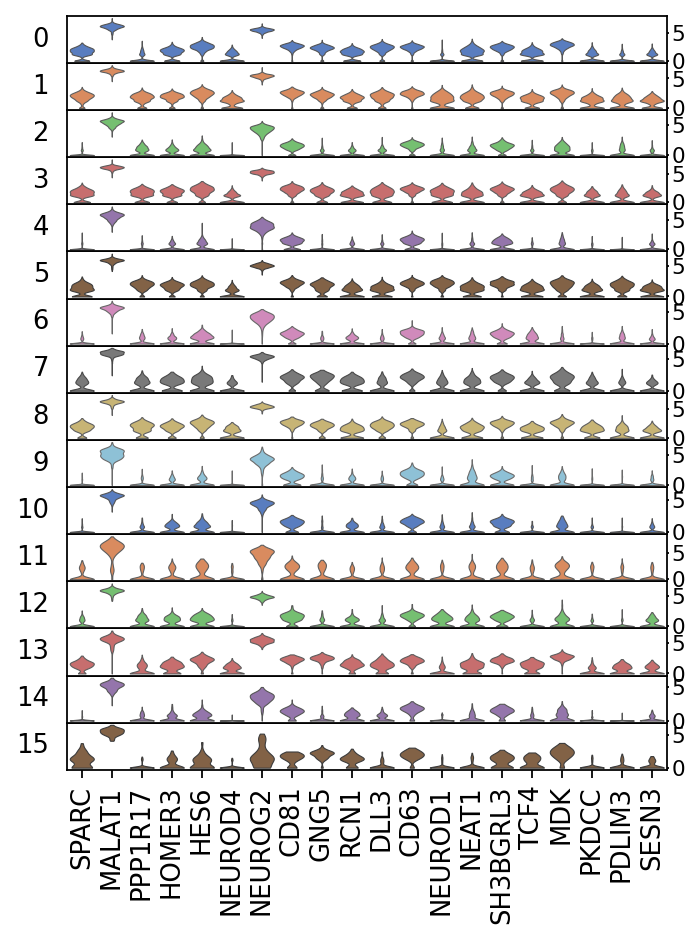

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes_cluster1, groupby='leiden', rotation=90)

# Save the work
option: export a set of csv using 
adata.write_csvs(results_file[:-5])

In [0]:
adata.write(results_file)

In [0]:
%ls

analysis_10xgenomics/        filtered_feature_bc_matrix.h5  scanpy_out/
barcodes.tsv.gz              possorted_genome_bam.bam       web_summary.html
filtered_feature_bc_matrix/  possorted_genome_bam.bam.bai
